# **Experiment_2.4**

In [ ]:
import numpy as np 
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
image_path= '/content/gdrive/MyDrive/soft computing /assignment_2/Dataset/training-a'


In [ ]:
cls_data = pd.read_csv('/content/gdrive/MyDrive/soft computing /assignment_2/Dataset/training-a.csv')
cls_data.head()
cls_data.columns
cls_data = cls_data.drop(columns=['original filename', 'scanid',
       'database name original', 'contributing team', 'database name'])
new_data=cls_data
new_data

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
...,...,...
19697,a19697.png,4
19698,a19698.png,3
19699,a19699.png,8
19700,a19700.png,3


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(210),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(210),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(new_data, image_path, train_transform)
test_data = Dataset(new_data, image_path, test_transform)

print("Trainig Samples: ",len(train_data))


Trainig Samples:  19702


In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(train_data, test_size = 0.2)
print(len(train_dataset))
print(len(test_dataset))

15761
3941


In [ ]:
batch_size = 100
num_iters = 50000
input_dim = 210*210 
num_hidden = 200  
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01  

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.relu_5= nn.ReLU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
 
iter_loss = [] 
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 210*210).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 210*210).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iter_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3001179695129395. Accuracy: 9.997462572951028
Iteration: 1000. Loss: 2.2995522022247314. Accuracy: 13.042375031717839
Iteration: 1500. Loss: 2.2940006256103516. Accuracy: 14.894696777467647
Iteration: 2000. Loss: 2.268392562866211. Accuracy: 20.02029941639178
Iteration: 2500. Loss: 2.203798770904541. Accuracy: 13.372240548084243
Iteration: 3000. Loss: 2.1675376892089844. Accuracy: 18.497843187008375
Iteration: 3500. Loss: 2.265963077545166. Accuracy: 17.711240801826946
Iteration: 4000. Loss: 2.1713638305664062. Accuracy: 16.54402435929967
Iteration: 4500. Loss: 2.383635997772217. Accuracy: 20.09642222786095
Iteration: 5000. Loss: 1.9825701713562012. Accuracy: 29.104288251712763
Iteration: 5500. Loss: 2.2739205360412598. Accuracy: 28.647551382897742
Iteration: 6000. Loss: 1.741182565689087. Accuracy: 33.95077391524994
Iteration: 6500. Loss: 1.6844723224639893. Accuracy: 32.732808931743214
Iteration: 7000. Loss: 1.7413265705108643. Accuracy: 37.224054808424256
Ite

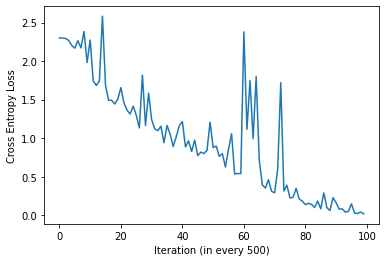

In [ ]:
plt.plot(iter_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# **Experiment_2.5**

In [ ]:
batch_size = 150
num_iters = 99500
input_dim = 210*210 
num_hidden = 250  
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01  

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
      
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
 
iter_loss = [] 
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 210*210).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 210*210).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iter_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2411515712738037. Accuracy: 18.70083735092616
Iteration: 1000. Loss: 2.2956044673919678. Accuracy: 21.06064450647044
Iteration: 1500. Loss: 2.230675220489502. Accuracy: 20.17254503933012
Iteration: 2000. Loss: 1.9000693559646606. Accuracy: 28.85054554681553
Iteration: 2500. Loss: 1.841797113418579. Accuracy: 31.23572697284953
Iteration: 3000. Loss: 1.7511398792266846. Accuracy: 25.14590205531591
Iteration: 3500. Loss: 2.32047963142395. Accuracy: 21.415884293326567
Iteration: 4000. Loss: 1.8590854406356812. Accuracy: 34.40751078406496
Iteration: 4500. Loss: 1.6341556310653687. Accuracy: 34.05227099720883
Iteration: 5000. Loss: 1.8112680912017822. Accuracy: 35.803095660999745
Iteration: 5500. Loss: 2.011322498321533. Accuracy: 35.04186754630804
Iteration: 6000. Loss: 1.8309274911880493. Accuracy: 29.129662522202487
Iteration: 6500. Loss: 1.511868953704834. Accuracy: 39.91372748033494
Iteration: 7000. Loss: 1.4331554174423218. Accuracy: 44.98858157827962
Iteration:

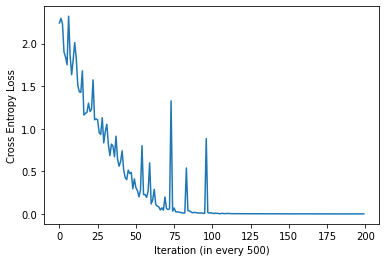

In [ ]:
plt.plot(iter_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()